In [1]:
import pandas as pd
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import KeyFunctions as me
import skopt as skopt
import warnings

warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before.")

RandState = 117

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(4, shuffle = True)

#Import Full R6g Dataset
df, labels = me.ConstructCombinedTriclosanDataset()

[train, test] = train_test_split(df, random_state = RandState, shuffle = True, train_size = 0.8)

y_tn = train.index
y_tt = test.index
X_tt = test.to_numpy()
X_tn = train.to_numpy()
display(labels)

['10-3', '10-4', '10-5', '10-7', '10-8', '10-9']

In [3]:
#Scale Dataset

from sklearn.preprocessing import StandardScaler

Scale = StandardScaler()

X_tn = Scale.fit_transform(X_tn)
X_tt = Scale.transform(X_tt)

In [4]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

df.columns = df.columns.astype(str)

SV = SVC(random_state = RandState)

SVscore = cross_val_score(SV, X_tn, y_tn, cv = cv)
display("Support Vector Cross Validation")
display(SVscore)
display(np.mean(SVscore))

SVcv = cross_validate(SV, X_tn, y_tn, cv = cv)
display(np.mean(SVcv['fit_time']))

'Support Vector Cross Validation'

array([0.5       , 0.3       , 0.3       , 0.22222222])

0.3305555555555556

0.0

In [5]:
params = dict()
params['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
params['C'] = (0.01, 100.00, 'log-uniform')
params['degree'] = [2, 3, 4, 5, 6]


Bayes = skopt.BayesSearchCV(SV, search_spaces = params, n_jobs = 6,
                      return_train_score = True, random_state = RandState, cv = cv)
SVBS = Bayes.fit(X_tn, y_tn)
display()

display(SVBS.best_params_)
ypred = SVBS.predict(X_tt)
display(SVBS.best_score_)
display(SVBS.cv_results_['std_test_score'][SVBS.best_index_])
display(SVBS.refit_time_)

OrderedDict([('C', 100.0), ('degree', 2), ('kernel', 'rbf')])

0.725

0.17853571071357124

0.0

In [6]:
from sklearn.metrics import confusion_matrix
y_pred = SVBS.predict(X_tt)

SVcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        SVcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(SVcounter))

CMNT = confusion_matrix(y_tt, y_pred, labels = labels)

'Total Predictions: 9'

'Total Errors: 0'

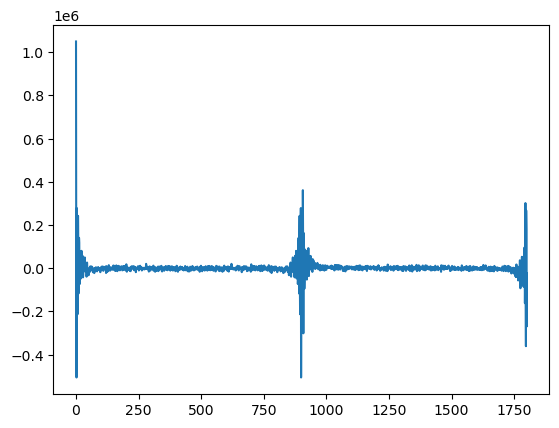

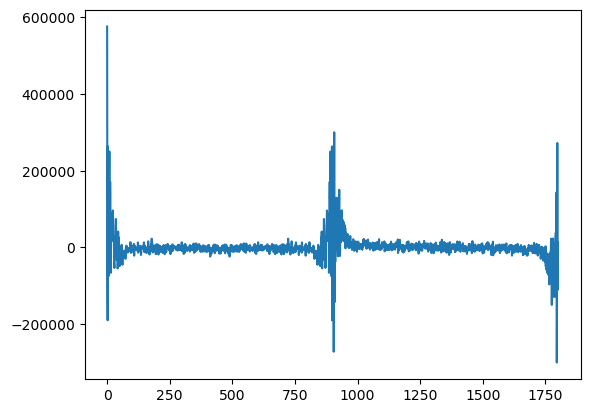

In [7]:
#Apply Fourier Transform to Training and Testing Data
#Fourier Transform Performs Best Without Scaling
X_tt = test.to_numpy()
X_tn = train.to_numpy()

X_tnf = np.fft.fft(X_tn)
X_ttf = np.fft.fft(X_tt)

#Data is stored as columns of all real values followed by columns of all imaginary values.
X_tnf = np.append(np.real(X_tnf), np.imag(X_tnf), axis = 1)
X_ttf = np.append(np.real(X_ttf), np.imag(X_ttf), axis = 1)

plt.figure()
plt.plot(X_tnf[1, :])
plt.figure()
plt.plot(X_tnf[7, :]);

In [8]:
#Calculate Cross Validation Scores
SV = SVC(random_state = RandState)

SVscore = cross_val_score(SV, X_tnf, y_tn, cv = cv)
display("Support Vector Cross Validation")
display(SVscore)
display(np.mean(SVscore))

SVcv = cross_validate(SV, X_tnf, y_tn, cv = cv)
display(np.mean(SVcv['fit_time']))

'Support Vector Cross Validation'

array([0.5       , 0.2       , 0.4       , 0.22222222])

0.3305555555555556

0.0007596015930175781

In [9]:
params = dict()
params['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
params['C'] = (0.01, 100.00, 'log-uniform')
params['degree'] = [2, 3, 4, 5, 6]


Bayes = skopt.BayesSearchCV(SV, search_spaces = params, n_jobs = 6,
                      return_train_score = True, random_state = RandState, cv = cv)
SVBS = Bayes.fit(X_tnf, y_tn)
display()

display(SVBS.best_params_)
ypred = SVBS.predict(X_ttf)
display(SVBS.best_score_)
display(SVBS.cv_results_['std_test_score'][SVBS.best_index_])
display(SVBS.refit_time_)

OrderedDict([('C', 14.728596491939689), ('degree', 2), ('kernel', 'linear')])

0.7416666666666666

0.059511903571190454

0.015624284744262695

In [10]:
y_pred = SVBS.predict(X_ttf)

SVcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        SVcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(SVcounter))

CMFT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 0, Predicted: 10-7; Actual: 10-5'

'Incorrect Prediction at 3, Predicted: 10-7; Actual: 10-5'

'Total Predictions: 9'

'Total Errors: 2'

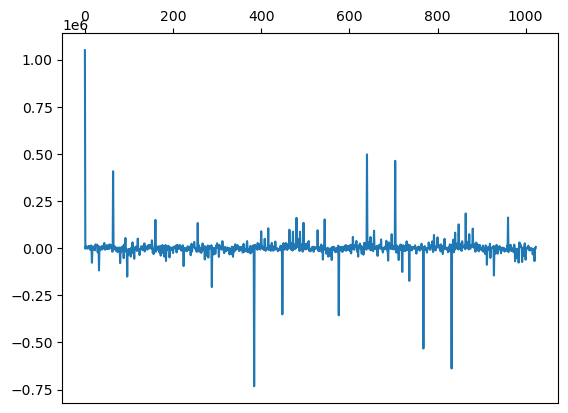

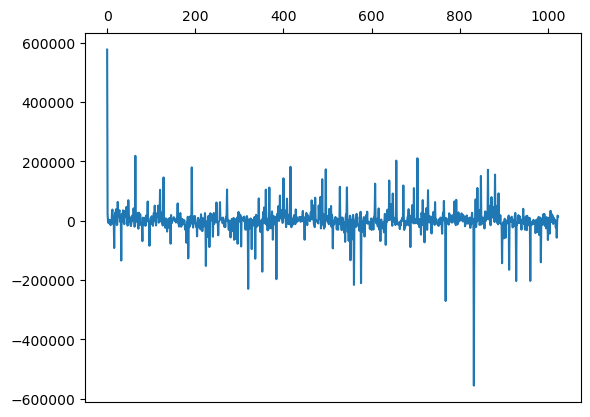

In [22]:
#Apply Welsh-Hadamard Transform to Training and Testing Data
from sympy.discrete.transforms import fwht, ifwht
X_tt = test.to_numpy()
X_tn = train.to_numpy()

X_tnh = np.apply_along_axis(fwht, axis=1, arr=X_tn)
X_tth = np.apply_along_axis(fwht, axis=1, arr=X_tt)

plt.figure()
plt.plot(X_tnh[1, :])
plt.figure()
plt.plot(X_tnh[7, :]);

In [23]:
#Calculate Cross Validation Scores
SV = SVC(random_state = RandState)

SVscore = cross_val_score(SV, X_tnh, y_tn, cv = cv)
display("Support Vector Cross Validation")
display(SVscore)
display(np.mean(SVscore))

SVcv = cross_validate(SV, X_tnh, y_tn, cv = cv)
display(np.mean(SVcv['fit_time']))

'Support Vector Cross Validation'

array([0.6       , 0.2       , 0.4       , 0.22222222])

0.3555555555555556

0.068825364112854

In [24]:
params = dict()
params['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
params['C'] = (0.01, 100.00, 'log-uniform')
params['degree'] = [2, 3, 4, 5, 6]


Bayes = skopt.BayesSearchCV(SV, search_spaces = params, n_jobs = 6,
                      return_train_score = True, random_state = RandState, cv = cv)
SVBS = Bayes.fit(X_tnh, y_tn)
display()

display(SVBS.best_params_)
ypred = SVBS.predict(X_tth)
display(SVBS.best_score_)
display(SVBS.cv_results_['std_test_score'][SVBS.best_index_])
display(SVBS.refit_time_)

OrderedDict([('C', 12.24632672071482), ('degree', 2), ('kernel', 'linear')])

0.7722222222222223

0.07876359377087681

0.09386587142944336

In [14]:
y_pred = SVBS.predict(X_tth)

SVcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        SVcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(SVcounter))

CMHT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 0, Predicted: 10-7; Actual: 10-5'

'Incorrect Prediction at 3, Predicted: 10-7; Actual: 10-5'

'Total Predictions: 9'

'Total Errors: 2'

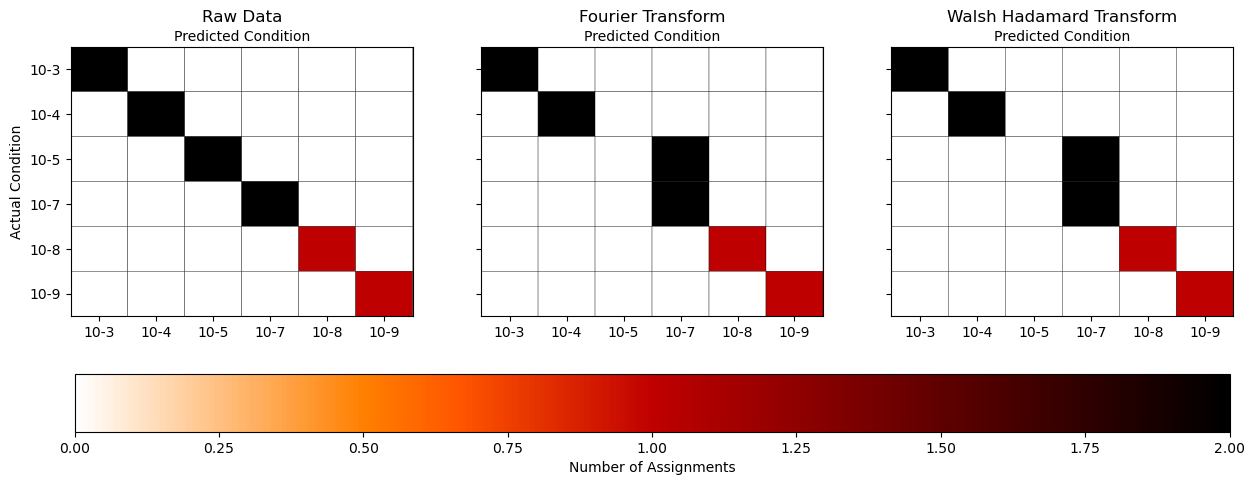

In [15]:

fig, axs = plt.subplots(1, 3, sharey = True, figsize = [15, 5])

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

pcm = axs[0].pcolor(CMNT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[0].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_yticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_ylabel("Actual Condition")
axs[0].set_xlabel("Predicted Condition")
axs[0].xaxis.set_label_position('top') 
axs[0].set_title('Raw Data');

axs[1].pcolor(CMFT, edgecolors = 'k', cmap = 'gist_heat_r');
plt.gca().invert_yaxis()
axs[1].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[1].set_title('Fourier Transform');
axs[1].set_xlabel("Predicted Condition")
axs[1].xaxis.set_label_position('top')

axs[2].pcolor(CMHT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[2].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels);
axs[2].set_title('Walsh Hadamard Transform');
axs[2].set_xlabel("Predicted Condition")
axs[2].xaxis.set_label_position('top')

fig.colorbar(pcm, ax = axs[:], location = 'bottom', label = 'Number of Assignments');